### попробуем предсказать стоимость машин и понять, от каких факторов зависит ценообразование на автомобили при помощи линейной регрессии

In [22]:
import pandas as pd
import statsmodels.formula.api as smf 
import seaborn as sns
import statsmodels.api as sm

In [2]:
cars = pd.read_csv('https://stepik.org/media/attachments/lesson/387691/cars.csv')
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [4]:
cars.duplicated().sum()

0

### Создадим первый признак - марку машины. Сколько всего уникальных марок машин в новом столбце? Удалите столбей CarName и car_ID - они не пригодятся

In [5]:
cars['car_model'] = cars['CarName'].apply(lambda x: x.split()[0])

In [6]:
cars = cars.drop(['CarName', 'car_ID'], axis=1)

In [7]:
cars.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,car_model
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,audi
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,audi


In [8]:
cars['car_model'].nunique()

28

### Теперь внимательнее посмотрите на уникальные значения company. Часть из них оказалась с ошибками!

In [9]:
cars['car_model'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [10]:
def car(model):
    model = model.lower()
    if model == 'vokswagen' or model == 'vw':
        return 'volkswagen'
    elif model == 'porcshce':
        return 'porsche'
    elif model == 'toyouta':
        return 'toyota'
    elif model == 'maxda':
        return 'mazda'
    else:
        return model

In [11]:
cars['car_model'] = cars['car_model'].apply(car)

In [12]:
cars.car_model.nunique()

22

### Отлично! Чтобы не перегружать модель большим количеством предикторов, оставим только часть из них:

'car_model', 'fueltype', 'aspiration','carbody', 'drivewheel', 'wheelbase', 'carlength','carwidth', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'boreratio','horsepower'


In [13]:
part_car = cars[['car_model', 'fueltype', 'aspiration','carbody', 
                'drivewheel', 'wheelbase', 'carlength','carwidth', 
                'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 
                'boreratio','horsepower', 'price']].copy()
part_car.head()

,car_model,fueltype,aspiration,carbody,drivewheel,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,boreratio,horsepower,price
0,alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,four,130,3.47,111,13495.0
1,alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,four,130,3.47,111,16500.0
2,alfa-romero,gas,std,hatchback,rwd,94.5,171.2,65.5,2823,ohcv,six,152,2.68,154,16500.0
3,audi,gas,std,sedan,fwd,99.8,176.6,66.2,2337,ohc,four,109,3.19,102,13950.0
4,audi,gas,std,sedan,4wd,99.4,176.6,66.4,2824,ohc,five,136,3.19,115,17450.0


### После этого посчитайте корреляцию между price и другими переменными. Чему равна корреляция между price и horsepower? Ответ округлите до 2 знаков после точки.

In [14]:
part_car.corr().round(2)

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,price
wheelbase,1.00,0.87,0.80,0.78,0.57,0.49,0.35,0.58
carlength,0.87,1.00,0.84,0.88,0.68,0.61,0.55,0.68
carwidth,0.80,0.84,1.00,0.87,0.74,0.56,0.64,0.76
curbweight,0.78,0.88,0.87,1.00,0.85,0.65,0.75,0.84
enginesize,0.57,0.68,0.74,0.85,1.00,0.58,0.81,0.87
boreratio,0.49,0.61,0.56,0.65,0.58,1.00,0.57,0.55
horsepower,0.35,0.55,0.64,0.75,0.81,0.57,1.00,0.81
price,0.58,0.68,0.76,0.84,0.87,0.55,0.81,1.00


### *наибольшая корреляция цены с curbweight, enginesize и horsepower*
## для номинативных переменных нужно применять метод One-Hot Encoding - вместо категориальных переменных будут фиктивные

In [15]:
part_car.dtypes

car_model          object
fueltype           object
aspiration         object
carbody            object
drivewheel         object
wheelbase         float64
carlength         float64
carwidth          float64
curbweight          int64
enginetype         object
cylindernumber     object
enginesize          int64
boreratio         float64
horsepower          int64
price             float64
dtype: object

In [16]:
df_dummy = pd.get_dummies(data=cars[['car_model', 'fueltype', 'aspiration', 
                                     'carbody', 'drivewheel', 'enginetype', 'cylindernumber']], drop_first = True)
# drop_first помогает избежать мультиколлинеарность 

In [17]:
df_dummy

,car_model_audi,car_model_bmw,car_model_buick,car_model_chevrolet,car_model_dodge,car_model_honda,car_model_isuzu,car_model_jaguar,car_model_mazda,car_model_mercury,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
201,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
202,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
203,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [18]:
part_cars_dummy = pd.get_dummies(data=part_car, drop_first = True)
part_cars_dummy.corr()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,price,car_model_audi,car_model_bmw,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
wheelbase,1.000000,0.874587,0.795144,0.776386,0.569329,0.488750,0.353294,0.577816,0.110017,0.147804,...,-0.204037,-0.183195,0.166152,-0.081174,0.261182,-0.309492,0.145842,-0.120709,0.037803,-0.081174
carlength,0.874587,1.000000,0.841118,0.877728,0.683360,0.606454,0.552623,0.682920,0.149405,0.171120,...,-0.274413,-0.118320,0.244053,-0.057877,0.259894,-0.400210,0.262981,-0.187445,0.100413,-0.057877
carwidth,0.795144,0.841118,1.000000,0.867032,0.735433,0.559150,0.640732,0.759325,0.246588,0.053412,...,-0.286211,-0.124446,0.348869,-0.013699,0.397690,-0.523135,0.209246,-0.183473,0.153516,-0.013699
curbweight,0.776386,0.877728,0.867032,1.000000,0.850594,0.648480,0.750739,0.835305,0.088743,0.145028,...,-0.413293,-0.080295,0.400878,-0.039196,0.264554,-0.576463,0.405490,-0.143903,0.187964,-0.039196
enginesize,0.569329,0.683360,0.735433,0.850594,1.000000,0.583774,0.809769,0.874145,0.017231,0.193885,...,-0.363334,-0.016508,0.562403,-0.184762,0.144878,-0.631431,0.511783,-0.111081,0.335555,-0.184762
boreratio,0.488750,0.606454,0.559150,0.648480,0.583774,1.000000,0.573677,0.553173,-0.109189,0.107399,...,-0.410383,0.326798,0.119509,0.000127,-0.007797,-0.164076,0.128365,-0.108774,0.054482,0.000127
horsepower,0.353294,0.552623,0.640732,0.750739,0.809769,0.573677,1.000000,0.808139,0.080472,0.177560,...,-0.427616,0.044752,0.431539,0.019250,0.110692,-0.639552,0.533544,-0.099600,0.280220,0.019250
price,0.577816,0.682920,0.759325,0.835305,0.874145,0.553173,0.808139,1.000000,0.108117,0.324731,...,-0.344270,0.016285,0.385991,-0.004544,0.249606,-0.697762,0.474978,-0.071388,0.199634,-0.004544
car_model_audi,0.110017,0.149405,0.246588,0.088743,0.017231,-0.109189,0.080472,0.108117,1.000000,-0.037890,...,0.116687,-0.052831,-0.048926,-0.026525,0.670425,-0.285185,-0.068467,-0.013164,-0.013164,-0.026525
car_model_bmw,0.147804,0.171120,0.053412,0.145028,0.193885,0.107399,0.177560,0.324731,-0.037890,1.000000,...,0.125060,-0.056621,-0.052436,-0.028428,-0.047985,-0.253894,0.396711,-0.014109,-0.014109,-0.028428


### Сначала построим небольшую модель всего с одним предиктором цены (price) – horsepower.

Какой процент изменчивости объясняет полученная модель? (округлите до целого)

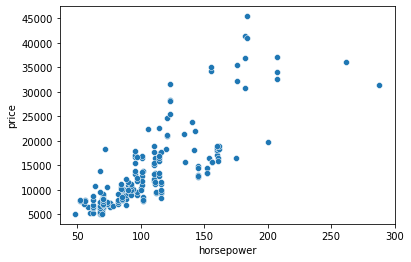

In [19]:
sns.scatterplot(data=part_cars_dummy, x='horsepower', y='price')

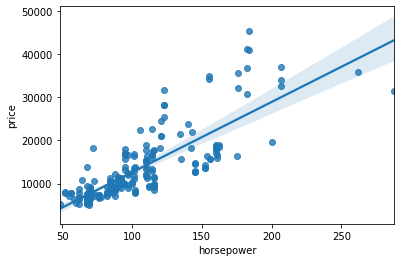

In [20]:
sns.regplot(data=part_cars_dummy, x='horsepower', y='price')

In [21]:
model1 = smf.ols('price ~ horsepower', part_cars_dummy).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     382.2
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           1.48e-48
Time:                        08:14:00   Log-Likelihood:                -2024.0
No. Observations:                 205   AIC:                             4052.
Df Residuals:                     203   BIC:                             4059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3721.7615    929.849     -4.003      0.0

### Промежуточные выводы
- Durbin-Watson - значение приемлемое (от 0 до 4)
- Cond. No. (мультиколлинеарность) - должен быть меньше 2
- coef = b1 = 163 - связь положительна
- процент изменчивости: 0.653 (65%)

### Теперь построим ещё две модели:

- модель со всеми предикторами
- модель со всеми предикторами, кроме марок машин

In [34]:
# модель со всеми предикторами

In [23]:
part_cars_dummy.columns

Index(['wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize',
       'boreratio', 'horsepower', 'price', 'car_model_audi', 'car_model_bmw',
       'car_model_buick', 'car_model_chevrolet', 'car_model_dodge',
       'car_model_honda', 'car_model_isuzu', 'car_model_jaguar',
       'car_model_mazda', 'car_model_mercury', 'car_model_mitsubishi',
       'car_model_nissan', 'car_model_peugeot', 'car_model_plymouth',
       'car_model_porsche', 'car_model_renault', 'car_model_saab',
       'car_model_subaru', 'car_model_toyota', 'car_model_volkswagen',
       'car_model_volvo', 'fueltype_gas', 'aspiration_turbo',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
 

In [36]:
Y = part_cars_dummy['price']
X = part_cars_dummy[['wheelbase', 'carlength', 'carwidth', 'curbweight', 
                     'enginesize', 'boreratio', 'horsepower', 'car_model_audi', 
                     'car_model_bmw', 'car_model_buick', 'car_model_chevrolet', 'car_model_dodge',
       'car_model_honda', 'car_model_isuzu', 'car_model_jaguar',
       'car_model_mazda', 'car_model_mercury', 'car_model_mitsubishi',
       'car_model_nissan', 'car_model_peugeot', 'car_model_plymouth',
       'car_model_porsche', 'car_model_renault', 'car_model_saab',
       'car_model_subaru', 'car_model_toyota', 'car_model_volkswagen',
       'car_model_volvo', 'fueltype_gas', 'aspiration_turbo',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two']]
X = sm.add_constant(X)
model_all = sm.OLS(Y, X).fit()
print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     81.09
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           4.86e-89
Time:                        09:40:27   Log-Likelihood:                -1804.2
No. Observations:                 205   AIC:                             3702.
Df Residuals:                     158   BIC:                             3858.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.472e+

In [35]:
# модель без марок машин
Y2 = part_cars_dummy['price']
X2 = part_cars_dummy[['wheelbase', 'carlength', 'carwidth', 'curbweight', 
                     'enginesize', 'boreratio', 'horsepower', 'fueltype_gas', 'aspiration_turbo',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two']]
X2 = sm.add_constant(X2)
model_3 = sm.OLS(Y2, X2).fit()
print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     72.32
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           9.86e-81
Time:                        09:40:22   Log-Likelihood:                -1881.6
No. Observations:                 205   AIC:                             3817.
Df Residuals:                     178   BIC:                             3907.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -1.7e+

# Выводы по моделям
- Большинство коэффициентов, связанных с марками машин, статистически незначимы
- Однако модель со всеми переменными лучше объясняет (на 4%) изменчивость дисперсии, и на 29% лучше по сравнению с моделью с одним предиктором - лошадиные силы
- стоит учитывать, что модель со всеми предикторами сильно усложняет модель, я бы избавился от большей части марок машин с учетом того, что профит относительно модели без марок хуже на 4%

*Выбранная модель объясняет примерно 90% дисперсии (окр. до целого). Среди предикторов 10 из 27 оказались не значимыми (p > 0.05). Пример интерпретации: при единичном изменении показателя horsepower, цена ВОЗРАСТАЕТ на  86.8164 (без округления).*